# Fraud Detection
![](https://www.recosenselabs.com/wp-content/uploads/2023/11/Leveraging-AI-for-Advanced-Lending-Fraud-Detection.jpg)

*Fraud detection is the process of using technology and analytics to identify and flag suspicious activities that indicate fraudulent behavior. It involves analyzing data, transaction patterns, and user behavior to uncover anomalies and protect against financial losses. This is a critical function for businesses in industries like banking and e-commerce to maintain customer trust and comply with regulations*

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import squarify
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import (wasserstein_distance, chi2_contingency)

from sklearn.preprocessing import (LabelEncoder, StandardScaler, OrdinalEncoder)
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    PrecisionRecallDisplay, RocCurveDisplay,
    average_precision_score
)

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
PATH_DATASET: str = "/kaggle/input/e-commerce-fraud-detection-dataset/transactions.csv"

In [3]:
data: pd.DataFrame = pd.read_csv(PATH_DATASET)
data.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [4]:
target: str = "is_fraud"
feature: list[str] = data.columns.tolist()[:-1]
SEED: int = 2025

print(f"Total features contained in the dataset: {len(feature)}")

Total features contained in the dataset: 16


# EDA

## Data Understanding

In [5]:
display(data.describe().T)
display(data.describe(include="object").T)
display(data.info())
print(f"\nTotal duplicated data: {data.duplicated().sum()}")
print(f"\nDataset size: {data.shape}")

,count,mean,std,min,25%,50%,75%,max
transaction_id,299695.0,149848.000000,86514.638800,1.00,74924.50,149848.00,224771.50,299695.00
user_id,299695.0,3002.559432,1732.309663,1.00,1501.00,3007.00,4504.00,6000.00
account_age_days,299695.0,973.397871,525.241409,1.00,516.00,975.00,1425.00,1890.00
total_transactions_user,299695.0,50.673321,5.976391,40.00,46.00,51.00,56.00,60.00
avg_amount_user,299695.0,148.142973,200.364624,3.52,46.19,90.13,173.45,4565.29
amount,299695.0,177.165279,306.926507,1.00,42.10,89.99,191.11,16994.74
promo_used,299695.0,0.153640,0.360603,0.00,0.00,0.00,0.00,1.00
avs_match,299695.0,0.837999,0.368453,0.00,1.00,1.00,1.00,1.00
cvv_result,299695.0,0.872110,0.333968,0.00,1.00,1.00,1.00,1.00
three_ds_flag,299695.0,0.784588,0.411109,0.00,1.00,1.00,1.00,1.00


,count,unique,top,freq
country,299695,10,US,32430
bin_country,299695,10,US,32295
channel,299695,2,web,152226
merchant_category,299695,5,electronics,60220
transaction_time,299695,297975,2024-03-10T13:10:03Z,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

None


Total duplicated data: 0

Dataset size: (299695, 17)


In [6]:
print(f"No fraud: {round(data['is_fraud'].value_counts()[0]/len(data)*100, 2)}% of the dataset")
print(f"Fraud: {round(data['is_fraud'].value_counts()[1]/len(data)*100, 2)}% of the dataset") 

No fraud: 97.79% of the dataset
Fraud: 2.21% of the dataset


### Initial Data Understanding (IDU) — Key Insights & Business Interpretation

---

In the initial stage of dataset exploration, a full analysis was conducted to understand the structure, condition, and quality of the data.  
The main goal was to detect dataset characteristics and potential risks before moving into the fraud detection modeling phase.

---

#### 1) No Missing Values

The dataset contains **zero missing values**, which provides several benefits:

- No imputation process needed (avoids potential bias).
- The model can learn directly from original behavioral patterns.
- The preprocessing pipeline becomes more efficient and less error-prone.

**Business impact:** complete data indicates reliable and consistent transaction logging, allowing the model to reflect real operational behavior.

---

#### 2) No Duplicate Records

No duplicate transactions were identified, meaning all entries are **unique observations**.

This is especially important in fraud detection because duplicates may cause:

- Data leakage (model appears artificially strong).
- Learning patterns that will not appear in real-world transactions.

---

#### 3) Dataset Size: ~300,000 Transactions

The dataset is sufficiently large to support a stable predictive model.

Benefits of a large dataset:

- Lower model variance.
- Better separation between fraud and non-fraud patterns.
- Suitable for models such as **XGBoost, LightGBM, and CatBoost**.

---

#### 4) Highly Imbalanced Class (Only ~2.2% Fraud)

Only **around 2.2%** of records are labeled as fraud — the key challenge.

Because of this imbalance:

- A naive model could reach **98% accuracy** just by predicting all transactions as non-fraud (but would be useless).
- **Accuracy is not a relevant metric.**

Better evaluation metrics include:

- AUPRC  
- Precision@K  
- Recall  
- Cost-based evaluation  

**Business meaning:** even a low fraud rate can generate significant loss if undetected.

---

#### 5) `transaction_id` and `user_id` Temporarily Removed

These variables behave mostly as identifiers rather than predictive features.

However, they can be useful for future feature engineering:

- User behavioral profiling
- Transaction velocity analysis
- Fraud probability history
- Window-based transaction frequency tracking

Therefore, they were dropped temporarily but remain candidates for future improvement.

---

#### 6) Numerical Feature Scaling Differences

Some numerical features have very different ranges.

Technical implications:

- Linear and logistic models require scaling (e.g., `StandardScaler`).
- Tree-based models (XGBoost, LightGBM, CatBoost) do **not** require scaling because they split based on thresholds.

This selective preprocessing ensures efficiency while preserving model performance.

---

#### 7) Incorrect Data Type in `transaction_time`

The transaction timestamp was originally a string and was converted into a proper datetime format.

This conversion enables valuable time-based features such as:

- Hour-of-day behavior  
- Weekend vs weekday pattern  
- Time since previous transaction  
- Rolling window statistics  
- Fraud pattern spikes  

These engineered features can significantly enhance fraud detection model performance.

---


## Univariate Analysis

*Conducting analysis of the shape and distribution of a feature*

![](https://keytodatascience.com/wp-content/uploads/2022/01/Univariate-Analysis-Statistics-KeytoDataScience.png)

In [7]:
# Fixed transaction_time data type (To make analysis easier)
data["transaction_time"] = pd.to_datetime(data["transaction_time"], utc=True)
print(f"Successfully changed transaction_time data type to: {data['transaction_time'].dtype}")

Successfully changed transaction_time data type to: datetime64[ns, UTC]


### Numeric Columns

In [8]:
# Creating a univariate numeric class
class UnivariateNumeric:
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df.select_dtypes(include=np.number)

    def __str__(self) -> str:
        return "[INFO] Successfully Created a Numeric Univariate Class"

    def __len__(self) -> int:
        return self.df.shape[1]
    
    def histogram_and_boxplot(self) -> None:
        n = len(self.df.columns)
    
        if n==0:
            print("There are no numeric columns in the DataFrame")
            return None
    
        fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
        if n==1:
            axes = np.array(axes)
    
        for i, col in enumerate(self.df):
            # Plot Histogram
            sns.histplot(self.df[col], bins=50, kde=False, ax=axes[i, 0], color='steelblue')
            axes[i, 0].set_title(f"Distribution of {col}", fontsize=12)
            axes[i, 0].set_xlabel(col)
            axes[i, 0].set_ylabel("Count")
    
            # Plot BoxPlot
            sns.boxplot(x=self.df[col], ax=axes[i, 1], color='tomato')
            axes[i, 1].set_title(f"BoxPlot of {col}", fontsize=12)
            axes[i, 1].set_xlabel(col)
    
        plt.tight_layout()
        plt.show()
    
    
    def violin_plot(self) -> None: 
        n = len(self.df.columns)
        if n==0:
            print("There are no numeric columns in the DataFrame")
            return None

        fig, axes = plt.subplots(4, 3, figsize=(15, 16))
        axes = axes.flatten()

        for i, col in enumerate(self.df):
            sns.violinplot(
                x=self.df[col], ax=axes[i], color='lightblue', inner='box'
            )
            axes[i].set_title(f"Violin Plot of {col}", fontsize=11)
            axes[i].set_xlabel(col)
            axes[i].grid(True, alpha=0.3)

        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

u_num = UnivariateNumeric(data)
print(u_num)
print(f"[INFO] Total numeric column: {len(u_num)}")

[INFO] Successfully Created a Numeric Univariate Class
[INFO] Total numeric column: 12


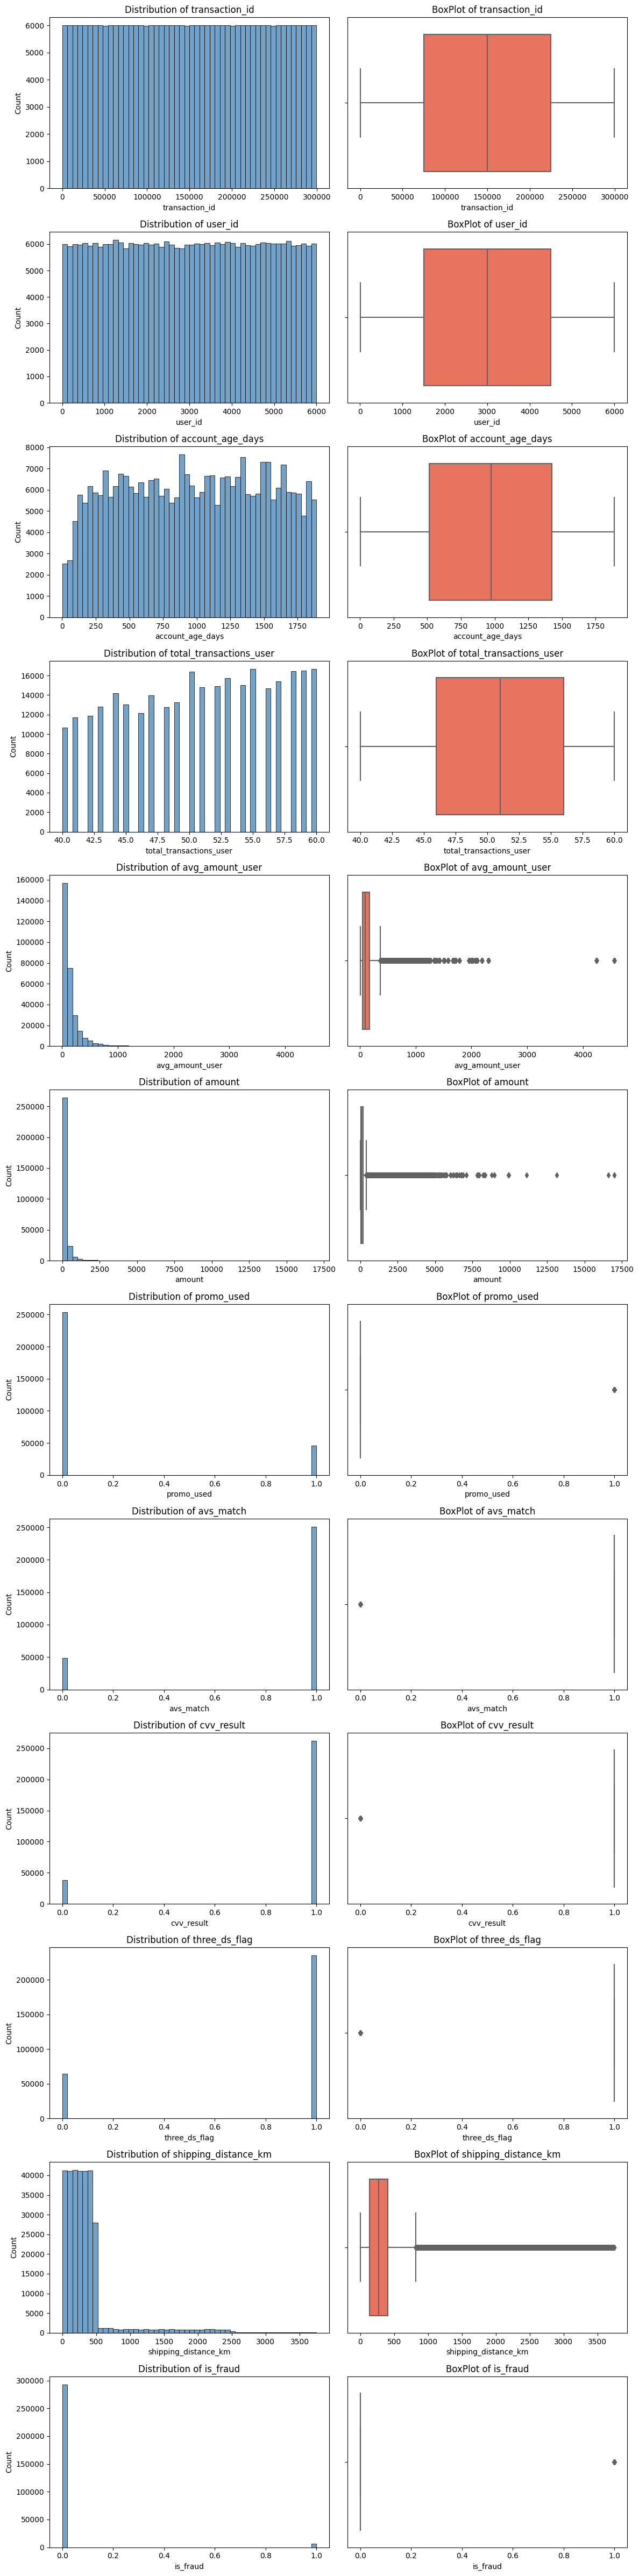

In [9]:
# Histogram and boxplot
u_num.histogram_and_boxplot()

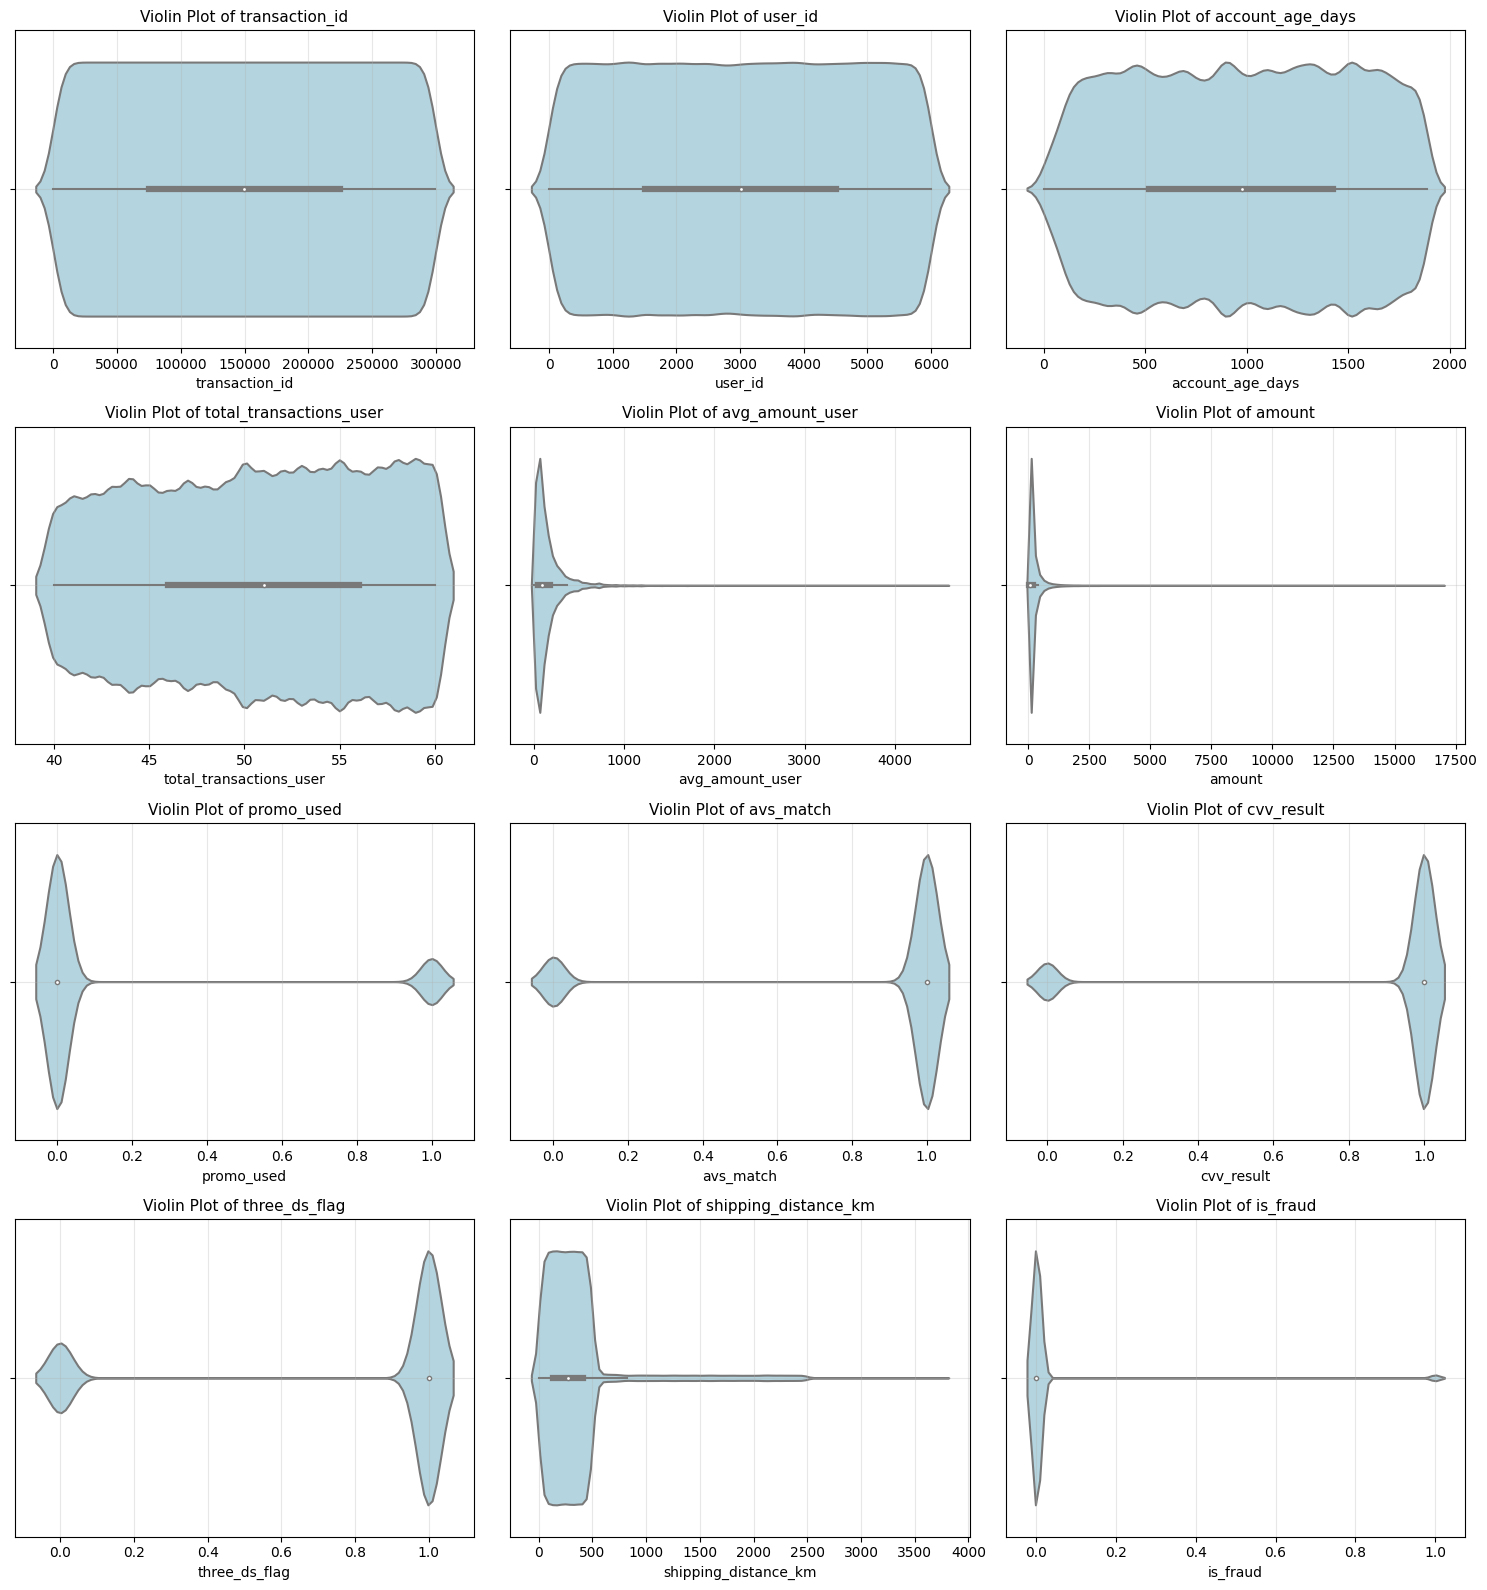

In [10]:
u_num.violin_plot()

### Key Information Extracted
------------------------------------------------------------------------------------------------------------------------------------------------------

#### 1) `transaction_id` and `user_id` Show No Meaningful Pattern

Based on distribution analysis and visual inspection, both features do not demonstrate informative patterns.  
They behave as unique identifiers per row and show no direct relationship with fraudulent behavior.

For the initial phase:

- These features are **not used as model inputs**,  
but they remain strong candidates for future feature engineering, such as:

- Transaction frequency per user  
- User behavior tracking  
- Merchant–user relational patterns  

---

#### 2) `amount` and `avg_amount_user` Contain Many Outliers

The high number of outliers in these features is reasonable because transaction values can vary significantly across users.

For now, the features are kept in their raw form; however, the presence of outliers indicates:

- Log transformation may help stabilize the distribution  
- Outliers may represent abnormal transaction behavior  
- These features have strong potential for detecting suspicious activity  

---

#### 3) `shipping_distance_km` Contains Extreme Outliers

Outliers in shipping distance are expected because movement in kilometers ranges from local delivery to long-distance or cross-border shipments.

For now, the feature is left unchanged, but:

- Log transformation or scaling may be considered  
- Extreme distance values may correspond to specific fraud patterns (e.g., shipping far from the buyer’s usual location)  

---

#### 4) `promo_used`, `avs_match`, `cvv_result`, and `three_ds_flag` Are Binary Features

These four features are already in an ideal format for modeling and require no additional preprocessing.

Binary features like these often carry strong signals related to:

- Transaction security  
- Card validation  
- Potential misuse of promotional systems  

These features are directly included in the model pipeline.

---

#### 5) Target Feature `is_fraud` Is Highly Imbalanced

The class distribution shows that only around **2.2%** of observations are labeled as fraud.

For now, the imbalance remains untouched, but there is strong potential for applying techniques such as:

- Undersampling  
- SMOTE or synthetic sampling methods  
- Class-weight adjustments  
- Advanced imbalance handling (ensemble or cost-sensitive learning)  

This imbalance is a natural characteristic of fraud datasets and becomes a primary consideration during modeling and evaluation.

---


In [11]:
# Creating a univariate object class
class UnivariateStr:
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df.select_dtypes(include='object')

    def __str__(self) -> str:
        return "[INFO] Successfully Created UnivariateStr class"

    def __len__(self) -> int:
        return self.df.shape[1]
        

    def countplot(self):
        n = len(self.df.columns)
        fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n))
        axes = axes.flatten()

        for i, col in enumerate(self.df.columns):
            sns.countplot(
                x=self.df[col],
                order=self.df[col].value_counts().index,
                palette="pastel",
                ax=axes[i]
            )
            axes[i].set_title(f"Countplot of {col}", fontsize=12)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
            axes[i].tick_params(axis="x", rotation=45)

        plt.tight_layout()
        plt.show()


    def barh_plot(self):
        n = len(self.df.columns)
        fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n))
        axes = axes.flatten()

        for i, col in enumerate(self.df.columns):
            sns.countplot(
                y=self.df[col],
                order=self.df[col].value_counts().index,
                palette="muted",
                ax=axes[i]
            )
            axes[i].set_title(f"Horizontal Countplot of {col}", fontsize=12)
            axes[i].set_xlabel("Count")
            axes[i].set_ylabel(col)

        plt.tight_layout()
        plt.show()

    
    def pie_plot(self):
        cols = self.df.columns
        n = len(cols)
    
        n_cols = 2
        n_rows = (n + 1) // 2   
    
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
        axes = axes.flatten()
    
        for i, col in enumerate(cols):
            counts = self.df[col].value_counts()
    
            axes[i].pie(
                counts.values,
                labels=counts.index,
                autopct='%1.1f%%',
                colors=sns.color_palette("pastel")
            )
            axes[i].set_title(f"Pie Chart of {col}")
    
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
    
        plt.tight_layout()
        plt.show()

    
    def treemap_plot(self):
        for col in self.df.columns:
            plt.figure(figsize=(8, 6))
            counts = self.df[col].value_counts()

            squarify.plot(
                sizes=counts.values,
                label=counts.index,
                alpha=0.7,
                color=sns.color_palette('pastel')
            )
            plt.title(f"Treemap of {col}")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

u_str = UnivariateStr(df=data)
print(u_str)
print(f"[INFO] total object column: {len(u_str)}")

[INFO] Successfully Created UnivariateStr class
[INFO] total object column: 4


In [12]:
# u_str.countplot()

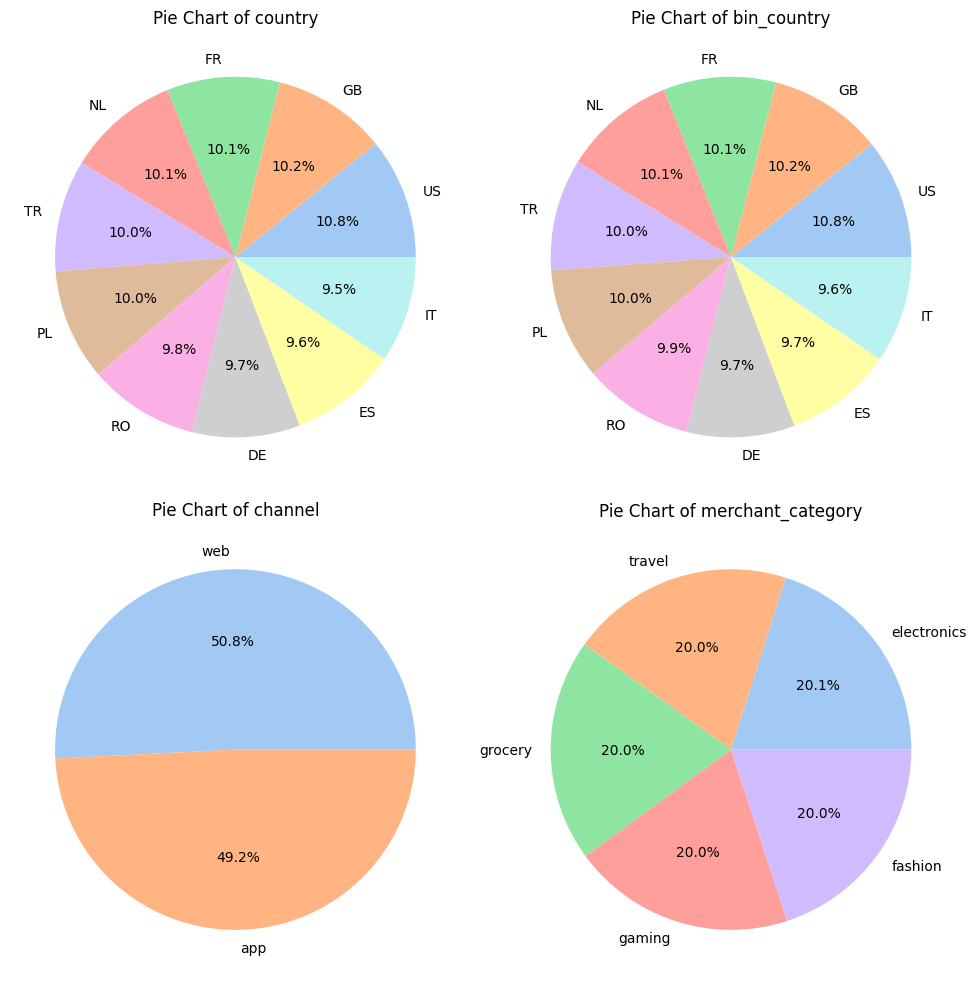

In [13]:
u_str.pie_plot()

#### Key Information Extracted
------------------------------------------------------------------------------------------------------------------------------------------------------

1. The value distribution across the selected features appears relatively balanced.

2. For now, all of these features will be included as model inputs.


## Bivariate Analysis

*Perform analysis and see the relationship between feature columns and target columns.*
![](https://media.geeksforgeeks.org/wp-content/uploads/20240520163311/Bivariate-Analysis.png)
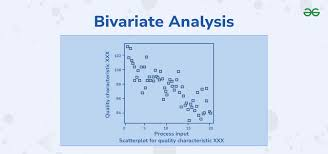

In [14]:
class BivariateNum:
    def __init__(self, df: pd.DataFrame, feature: list[str], target: str) ->None:
        self.df = df.copy()
        self.feature = self.df[feature].select_dtypes(include=np.number)
        self.target = self.df[target]
        self.target_name = target

    def __str__(self) ->str:
        return "[INFO] Successfully created BivariateNum object"

    def __len__(self) ->int:
        return self.feature.shape[1]


    def histogram_boxplot(self, sample_major=5000):
        n = len(self.feature.columns)
        fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
        axes = axes.flatten()

        # Sampling the majority class to be fair
        df_balanced = self._balanced_sample(sample_major)

        for i, col in enumerate(self.feature.columns):

            # Histogram balanced
            sns.histplot(
                data=df_balanced, x=col, hue=self.target_name,
                stat="density",        # important for imbalance
                common_norm=False,     
                multiple="layer",      
                alpha=0.4,
                ax=axes[i*2],
                palette="Set2"
            )
            axes[i*2].set_title(f"[Histogram] {col} vs {self.target_name}")

            # Boxplot balanced
            sns.boxplot(
                data=df_balanced,
                x=self.target_name,
                y=col,
                palette="Set2",
                ax=axes[i*2+1]
            )
            axes[i*2+1].set_title(f"[Boxplot] {col} vs {self.target_name}")

        plt.tight_layout()
        plt.show()


    def violin_plot(self, sample_major=5000):
        n = len(self.feature.columns)
        fig, axes = plt.subplots(n, 1, figsize=(10, 4*n))
        axes = axes.flatten()

        df_balanced = self._balanced_sample(sample_major)

        for i, col in enumerate(self.feature.columns):
            sns.violinplot(
                data=df_balanced,
                x=self.target_name,
                y=col,
                palette="Pastel1",
                inner="quartile",
                bw_adjust=0.7,     # stabilisasi minor class
                ax=axes[i]
            )
            axes[i].set_title(f"[Violin] {col} vs {self.target_name}")

        plt.tight_layout()
        plt.show()


    def kde_plot(self, sample_major=5000):
        n = len(self.feature.columns)
        fig, axes = plt.subplots(n, 1, figsize=(10, 4*n))
        axes = axes.flatten()

        df_balanced = self._balanced_sample(sample_major)

        for i, col in enumerate(self.feature.columns):

            sns.kdeplot(
                data=df_balanced,
                x=col,
                hue=self.target_name,
                fill=True,
                alpha=0.3,
                bw_adjust=0.7,           # important for minor classes
                common_norm=False,        
                ax=axes[i],
                palette="Set2"
            )
            axes[i].set_title(f"[KDE] {col} vs {self.target_name}")

        plt.tight_layout()
        plt.show()


    def overlap_score(self):
        print("\n[INFO] Calculating the distribution distance between classes (Wasserstein Distance)\n")

        classes = self.df[self.target_name].unique()
        if len(classes) != 2:
            raise ValueError("Target must be binary for overlap analysis.")

        c0 = self.df[self.target_name] == classes[0]
        c1 = self.df[self.target_name] == classes[1]

        scores = {}
        for col in self.feature.columns:
            d = wasserstein_distance(self.df.loc[c0, col], self.df.loc[c1, col])
            scores[col] = d

        # Sort from most informative
        sorted_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))

        for k, v in sorted_scores.items():
            print(f"{k:<25}  |  overlap distance = {v:.4f}")

        return sorted_scores


    def _balanced_sample(self, sample_major):
        """
        Taking a small sample from the majority class to be visually fair.
        """
        classes = self.df[self.target_name].unique()
        c0 = self.df[self.target_name] == classes[0]
        c1 = self.df[self.target_name] == classes[1]

        df_major = self.df.loc[c0]
        df_minor = self.df.loc[c1]

        # take a majority sample
        if len(df_major) > sample_major:
            df_major = df_major.sample(sample_major, random_state=42)

        return pd.concat([df_major, df_minor])

biv_num = BivariateNum(df=data, feature=feature, target=target)
print(biv_num)
print(f"Total features :{len(biv_num)}")

[INFO] Successfully created BivariateNum object
Total features :11


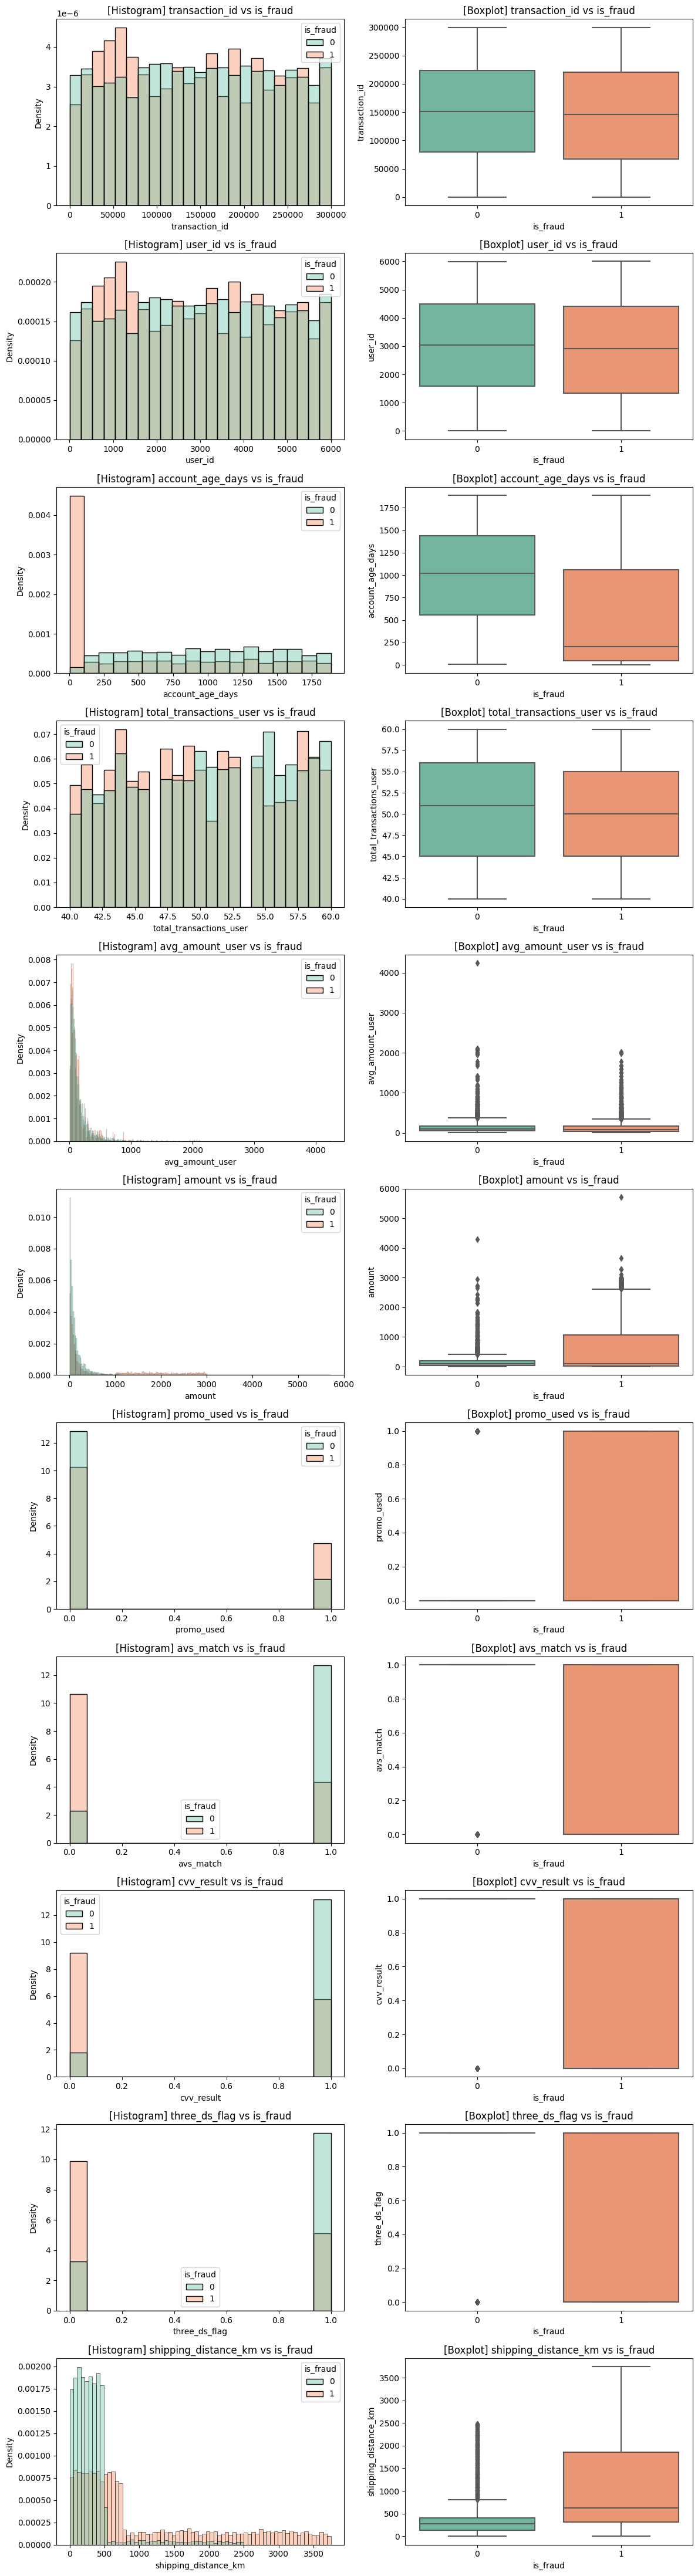

In [15]:
biv_num.histogram_boxplot()

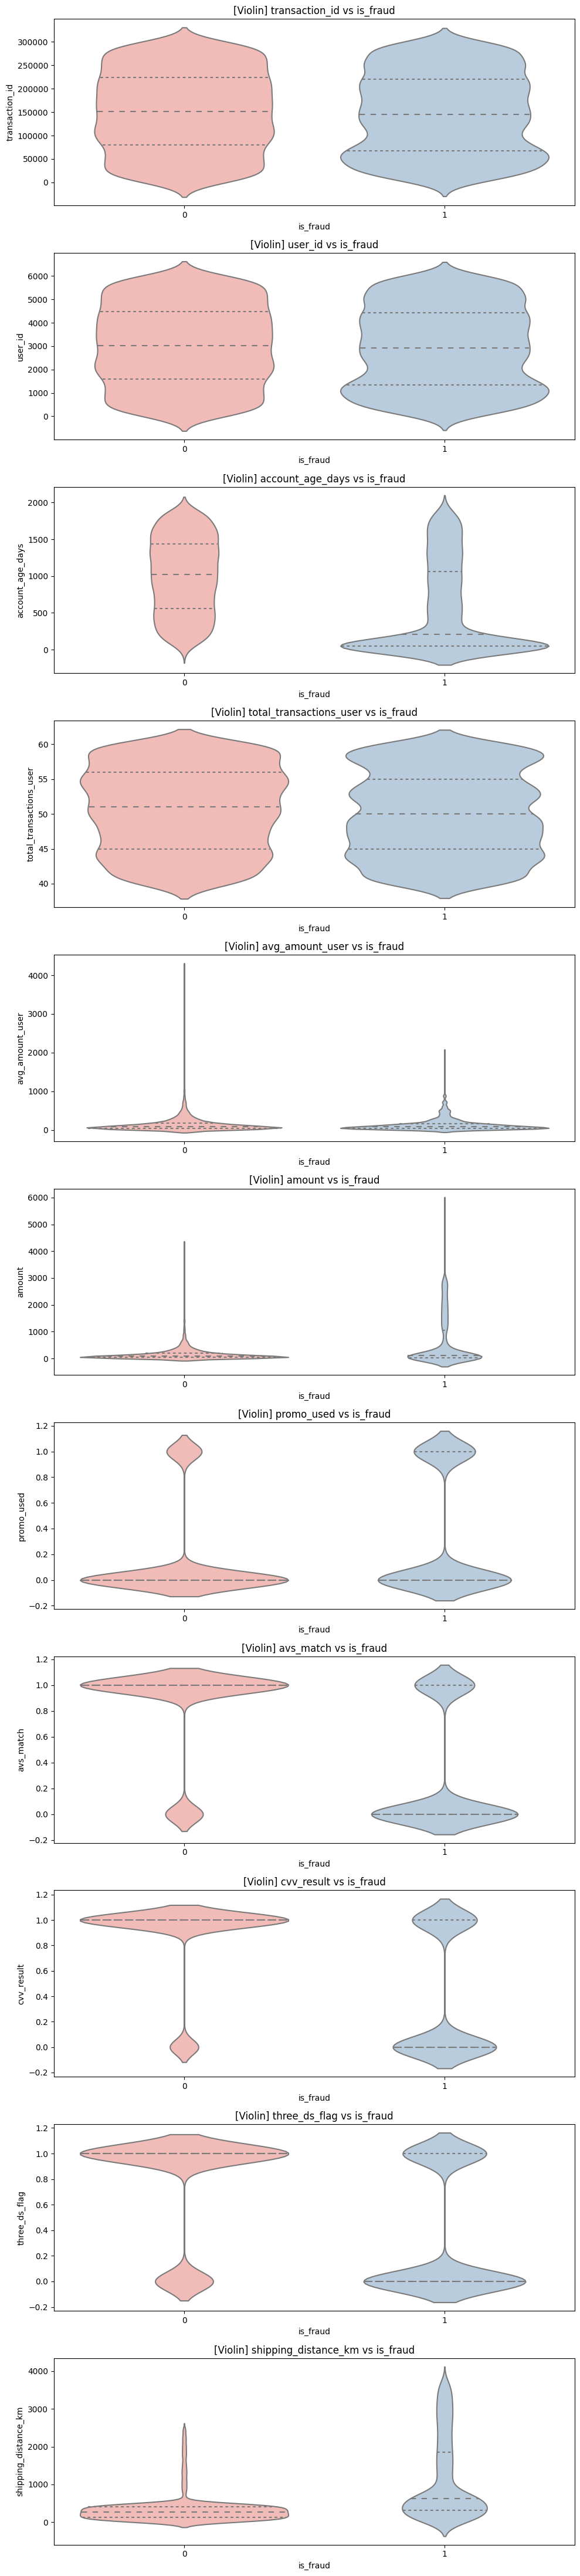

In [16]:
biv_num.violin_plot()

In [17]:
biv_num.overlap_score()


[INFO] Calculating the distribution distance between classes (Wasserstein Distance)

transaction_id             |  overlap distance = 3821.3956
shipping_distance_km       |  overlap distance = 786.1361
amount                     |  overlap distance = 438.2440
account_age_days           |  overlap distance = 430.3143
user_id                    |  overlap distance = 76.5048
avg_amount_user            |  overlap distance = 6.9633
total_transactions_user    |  overlap distance = 0.6955
avs_match                  |  overlap distance = 0.5601
cvv_result                 |  overlap distance = 0.4979
three_ds_flag              |  overlap distance = 0.4539
promo_used                 |  overlap distance = 0.1653


{'transaction_id': 3821.3956335558505,
 'shipping_distance_km': 786.1360605705538,
 'amount': 438.24401103542755,
 'account_age_days': 430.31432427548987,
 'user_id': 76.50482747507426,
 'avg_amount_user': 6.963333247718468,
 'total_transactions_user': 0.6954707933091533,
 'avs_match': 0.5601264986290613,
 'cvv_result': 0.4978858385742614,
 'three_ds_flag': 0.453856745225687,
 'promo_used': 0.1653441125827645}

### Key Insights Extracted
------------------------------------------------------------------------------------------------------------------------------------------------------

#### 1) `transaction_id` and `user_id` Have No Relevant Predictive Pattern

Both features behave as unique identifiers and show no meaningful relationship with fraud.

Since they do not provide predictive signal and may introduce noise, these features are excluded from the current model input.  
However, they may still serve as a foundation for future feature engineering.

---

#### 2) `account_age_days` is a Strong Predictor

Newer accounts tend to be more vulnerable to fraudulent behavior.

The distribution shows that most fraudulent accounts are much newer compared to legitimate ones — a common pattern in fraud detection within financial services.

---

#### 3) Fraud Accounts Tend to Have Fewer Historical Transactions

The feature `total_transactions_user` reveals that many fraudulent transactions originate from new accounts with very few previous activities.

This aligns with common fraud behavior observed in e-commerce, fintech, and banking systems:

- Account is newly created →  
- Performs a few normal transactions →  
- Executes fraudulent activity →  
- Account is abandoned  

---

#### 4) `avg_amount_user` Has Very Small Distribution in Fraud Cases

Fraudulent users often have very limited transaction history, resulting in a lower average transaction value.

This aligns with the intuition that fake or newly created accounts do not accumulate historical spending behavior.

---

#### 5) Fraudulent Transactions Tend to Have Higher `amount`

Fraud transactions frequently involve large monetary values.

Fraudsters typically target:

- High-value purchases  
- Expensive goods  
- Transactions with high resale potential  

Since financial gains increase with transaction size, higher amounts correlate strongly with fraud.

---

#### 6) `promo_used` Appears More Frequently in Fraud Cases

Fraudsters often exploit promotional systems to maximize value with minimal risk.

Typical behavior includes:

- Using coupons, cashback, or promotions  
- Reducing upfront financial risk before chargeback or stolen-card usage  

---

#### 7) `avs_match` Shows a High Rate of Mismatch in Fraud Transactions

AVS mismatch indicates that the billing address does not match the cardholder.

This commonly occurs in:

- Stolen card transactions  
- Fake identities  
- Address manipulation to bypass verification  

This is a strong fraud signal in e-commerce.

---

#### 8) `cvv_result` Often Shows Mismatch in Fraud Cases

Mismatch in CVV suggests that the fraudster does not possess full card information.

This pattern is highly consistent with carding-based fraud.

---

#### 9) `three_ds_flag`: Fraud More Common in Non-3DS Transactions

3D Secure adds additional authentication layers.

Fraudsters avoid it because it requires OTP or additional identity verification.  
Therefore, non-3DS transactions are significantly more vulnerable and appear more frequently in the fraud class.

---

#### 10) `shipping_distance_km`: Fraud More Common in Large-Distance Shipments

Fraudulent transactions often involve abnormal or extreme shipping distances, which may indicate:

- Identity masking  
- Fake delivery addresses  
- Attempts to avoid behavior-based detection  

Sudden extreme values in distance act as a strong anomaly signal.

---

### Strongest Predictors

Based on violin plot analysis and Wasserstein distance comparison, the most influential features are:

- `shipping_distance_km`
- `amount`
- `account_age_days`
- `avs_match`
- `cvv_result`
- `three_ds_flag`

These features show clear separation between fraud and non-fraud classes.

---

### Supportive Predictors

While not as strong individually, the following features provide meaningful context and are included in the model:

- `promo_used`
- `avg_amount_user`
- `total_transactions_user`

These features help strengthen borderline decision cases and improve overall fraud detection robustness.

---


In [18]:
class BivariateStr:
    def __init__(
        self, 
        df: pd.DataFrame, 
        feature: list[str], 
        target: str,
        rare_threshold: float = 0.01,
        max_categories: int = 50
    ):

        self.df = df
        self.target = target
        self.rare_threshold = rare_threshold
        self.max_categories = max_categories

        # Take only object/category features
        self.feature_cols = [
            col for col in feature
            if self.df[col].dtype == "object" or self.df[col].dtype.name == "category"
        ]


    def _handle_rare(self, series):
        """Group rare categories for stability."""
        freq = series.value_counts(normalize=True)
        rare_labels = freq[freq < self.rare_threshold].index
        return series.replace(rare_labels, "RARE")


    def _cramers_v(self, x, y):
        """Calculate Cramer's V (skip if there are too many categories)."""
        if x.nunique() > self.max_categories:
            return np.nan

        confusion = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion)[0]
        n = confusion.sum().sum()
        phi2 = chi2 / n
        r, k = confusion.shape
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
        rcorr = r - ((r - 1)**2)/(n - 1)
        kcorr = k - ((k - 1)**2)/(n - 1)
        return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


    def analyze(self, show_plot=True):
        results = []

        for col in self.feature_cols:

            nunique = self.df[col].nunique()

            # Skip features with too many categories
            if nunique > self.max_categories:
                print(f"[SKIP] {col} skipped (too many categories): {nunique})")
                continue

            # Fetch only the necessary columns → speeds things up a lot
            temp = self.df[[col, self.target]].copy()
            temp[col] = self._handle_rare(temp[col])

            # Summary
            summary = (
                temp.groupby(col)[self.target]
                .agg(["count", "sum", "mean"])
                .rename(columns={"sum": "fraud_count", "mean": "fraud_rate"})
                .sort_values("fraud_rate", ascending=False)
            )

            # Cramer's V
            summary["cramers_v"] = self._cramers_v(temp[col], temp[self.target])

            results.append((col, summary))

            if show_plot:
                self._plot_bivariate(temp, col, summary)

        return results


    def _plot_bivariate(self, df, col, summary):
        """Plot count + fraud-rate."""
        plt.figure(figsize=(10, 5))

        order = summary.index.tolist()
        counts = summary["count"]
        fraud_rate = summary["fraud_rate"]

        # Plot count
        sns.barplot(
            x=order,
            y=counts,
            color="skyblue"
        )

        plt.xticks(rotation=45)

        # Secondary axis → fraud rate
        ax2 = plt.twinx()
        ax2.plot(
            order,
            fraud_rate,
            color="red",
            marker="o",
            linewidth=2
        )
        ax2.set_ylabel("Fraud Rate", color="red")

        plt.title(f"[Bivariate] {col} vs {self.target}")
        plt.tight_layout()
        plt.show()
        plt.close()

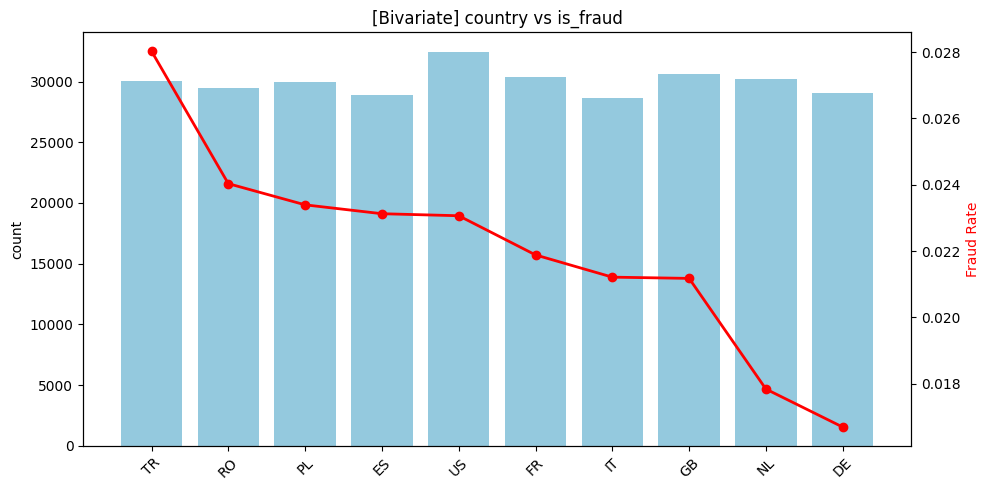

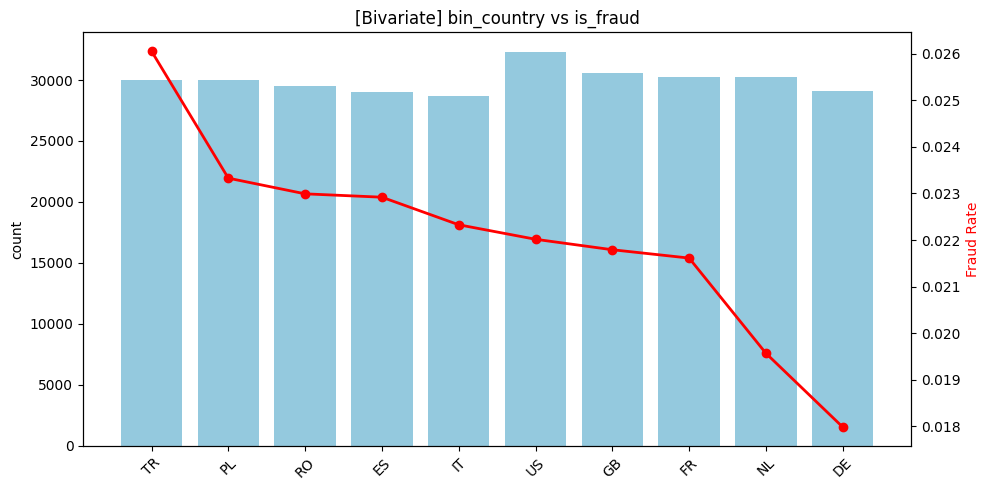

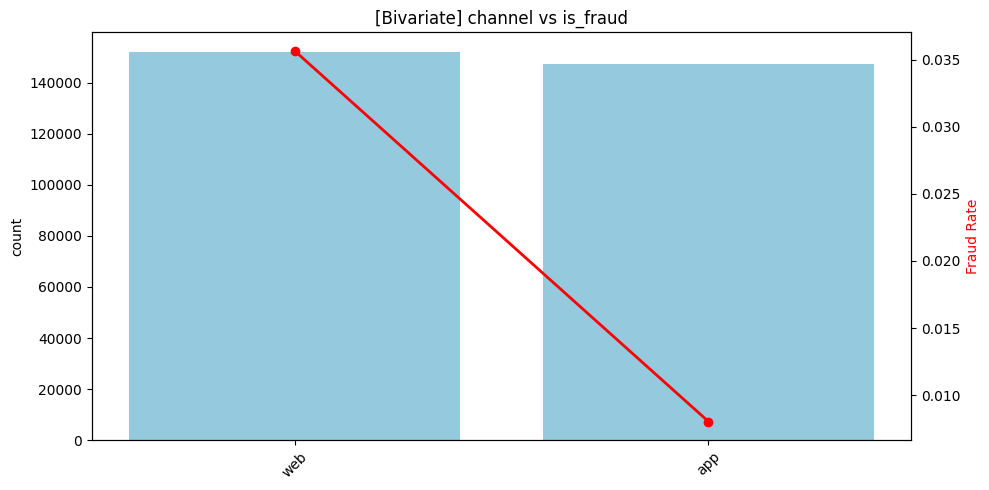

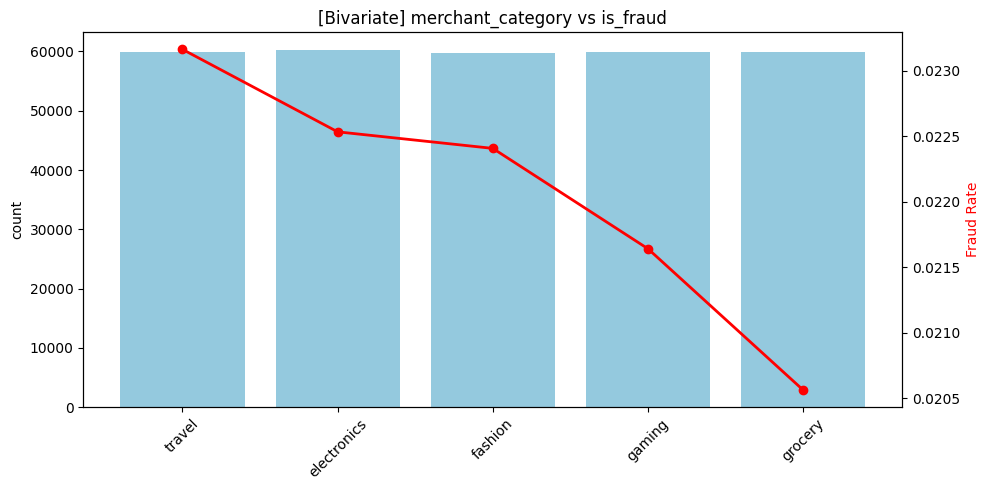

[('country',
           count  fraud_count  fraud_rate  cramers_v
  country                                           
  TR       30074          843    0.028031   0.019798
  RO       29501          709    0.024033   0.019798
  PL       29965          701    0.023394   0.019798
  ES       28885          668    0.023126   0.019798
  US       32430          748    0.023065   0.019798
  FR       30343          664    0.021883   0.019798
  IT       28615          607    0.021213   0.019798
  GB       30602          648    0.021175   0.019798
  NL       30220          539    0.017836   0.019798
  DE       29060          485    0.016690   0.019798),
 ('bin_country',
               count  fraud_count  fraud_rate  cramers_v
  bin_country                                           
  TR           29972          781    0.026058   0.012819
  PL           29963          699    0.023329   0.012819
  RO           29532          679    0.022992   0.012819
  ES           29058          666    0.022920  

In [19]:
biv = BivariateStr(data, feature=feature, target=target)
biv.analyze()

### Key Insights
------------------------------------------------------------------------------------------------------------------------------------------------------

- The distribution of fraud cases appears relatively balanced across most features, **except for the `channel` feature**, where fraud occurrences are significantly more frequent on the **web platform**.

- For further analysis, the following steps could be valuable:
  - **Time series analysis** based on the `transaction_time` feature
  - **Multivariate analysis** to explore feature interactions
  - **Hypothesis testing** to validate statistical relationships


## Preprocessing

In [20]:
# Remove unused features based on EDA stage
data.drop(columns=['transaction_id', 'user_id'], inplace=True, axis=1)

### Feature Selection (Round 1)
------------------------------------------------------------------------------------------------------------------------------------------------------

At this stage, the following features are temporarily excluded:

- `transaction_id`
- `user_id`

These features will be reviewed later to determine whether they hold potential value (e.g., leakage signal, frequency-based features, or behavioral pattern extraction).


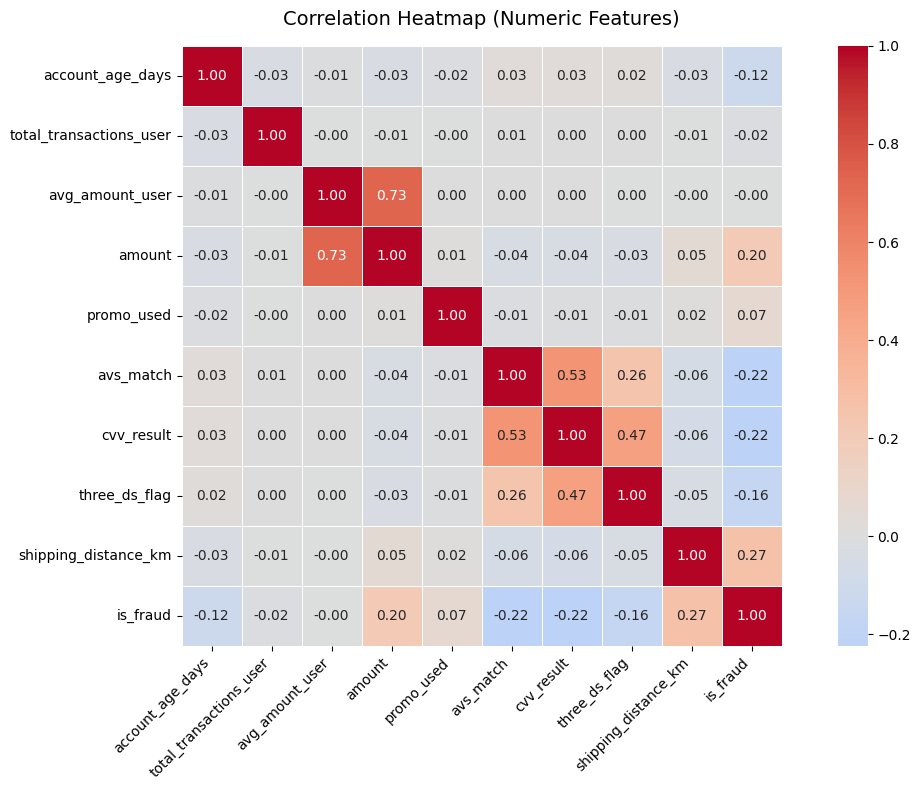

In [21]:
# Check correlation
plt.figure(figsize=(12, 8))

correlations = data.select_dtypes(include=np.number).corr()

sns.heatmap(
    correlations,
    annot=True,               
    fmt=".2f",                 
    cmap="coolwarm",           
    center=0,                  
    linewidths=0.5,            
    cbar=True,
    square=True                
)

plt.title("Correlation Heatmap (Numeric Features)", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


### Insights Extracted
------------------------------------------------------------------------------------------------------------------------------------------------------

Based on the heatmap analysis, the following decisions were made:

- `avg_amount_user`
- `promo_used`

Both features are excluded from the current modeling phase.

These features show very weak correlation values within the range: **-1 < x < 1**, indicating minimal linear influence on the target variable and low contribution to predictive power.


In [22]:
# Create features that will be selected for the next process
data_corr = data.drop(columns=['avg_amount_user', 'promo_used'], axis=1).copy()
data_corr.columns

Index(['account_age_days', 'total_transactions_user', 'amount', 'country',
       'bin_country', 'channel', 'merchant_category', 'avs_match',
       'cvv_result', 'three_ds_flag', 'transaction_time',
       'shipping_distance_km', 'is_fraud'],
      dtype='object')

### Additional Notes
------------------------------------------------------------------------------------------------------------------------------------------------------

For now, only a heatmap was applied during the first phase of feature selection.

Further refinement can be done using:

- **ANOVA statistical testing**
- **Feature importance from models such as:**
  - XGBoost
  - CatBoost
  - LightGBM

These methods can help validate feature relevance and guide more robust feature elimination or selection in the next iteration.


### Feature Engineering 1

In [23]:
# Processing and creating new features from the transaction time feature
data_corr['transaction_time'].head()

0   2024-01-06 04:09:39+00:00
1   2024-01-09 20:13:47+00:00
2   2024-01-12 06:20:11+00:00
3   2024-01-15 17:00:04+00:00
4   2024-01-17 01:27:31+00:00
Name: transaction_time, dtype: datetime64[ns, UTC]

In [24]:
# Conversion by country ->
country_tz = {
    'US': 'America/New_York',
    'GB': 'Europe/London',
    'FR': 'Europe/Paris',
    'NL': 'Europe/Amsterdam',
    'TR': 'Europe/Istanbul',
    'PL': 'Europe/Warsaw',
    'RO': 'Europe/Bucharest',
    'DE': 'Europe/Berlin',
    'ES': 'Europe/Madrid',
    'IT': 'Europe/Rome'
}

data_corr['local_time'] = data_corr.apply(
    lambda row: row['transaction_time'].tz_convert(country_tz[row['country']]),
    axis=1
)

data_corr['local_time'] = pd.to_datetime(data_corr['local_time'], utc=True)
data_corr['local_time'].head()

0   2024-01-06 04:09:39+00:00
1   2024-01-09 20:13:47+00:00
2   2024-01-12 06:20:11+00:00
3   2024-01-15 17:00:04+00:00
4   2024-01-17 01:27:31+00:00
Name: local_time, dtype: datetime64[ns, UTC]

In [25]:
# Creating new features
data_corr['hour'] = data_corr['local_time'].dt.hour
data_corr['day'] = data_corr['local_time'].dt.day
data_corr['month'] = data_corr['local_time'].dt.month
data_corr['weekday'] = data_corr['local_time'].dt.dayofweek 

data_corr[['hour', 'day', 'month', 'weekday']].head()

,hour,day,month,weekday
0,4,6,1,5
1,20,9,1,1
2,6,12,1,4
3,17,15,1,0
4,1,17,1,2


In [26]:
# Binning
data_corr['evening'] = np.where(
    data_corr['hour'].between(6, 17),   
    'no',
    'yes'
)

data_corr['weekend'] = np.where(
    data_corr['weekday'].isin([5, 6]),
    'yes',      
    'no'       
)

data_corr[['evening', 'weekend']].head()

,evening,weekend
0,yes,yes
1,yes,no
2,no,no
3,no,no
4,yes,no


In [27]:
# Performing transformations on datetime features
def time_features(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()
    
    time_range = {
        'month': 12,
        'wd': 7,
        'hour': 24
    }

    # For day feature
    df['days_in_month'] = df['local_time'].dt.days_in_month
    df['time_day_sin'] = np.sin(df['day'] * (2 * np.pi / df['days_in_month']))
    df['time_day_cos'] = np.cos(df['day'] * (2 * np.pi / df['days_in_month']))

    df.drop(columns=['days_in_month'], inplace=True)
    
    # Loop to create sin/cos features
    for time, col in zip(
        [df['month'], df['weekday'], df['hour']], 
        ['month', 'wd', 'hour']
    ):
        tau = 2*np.pi
        df[f'time_{col}_sin'] = np.sin(time * (tau / time_range[col]))
        df[f'time_{col}_cos'] = np.cos(time * (tau / time_range[col]))
    
    return df


In [28]:
data_corr = data_corr.pipe(time_features)
data_corr.head()

,account_age_days,total_transactions_user,amount,country,bin_country,channel,merchant_category,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud,local_time,hour,day,month,weekday,evening,weekend,time_day_sin,time_day_cos,time_month_sin,time_month_cos,time_wd_sin,time_wd_cos,time_hour_sin,time_hour_cos
0,141,47,84.75,FR,FR,web,travel,1,1,1,2024-01-06 04:09:39+00:00,370.95,0,2024-01-06 04:09:39+00:00,4,6,1,5,yes,yes,0.937752,0.347305,0.5,0.866025,-0.974928,-0.222521,0.866025,5.000000e-01
1,141,47,107.90,FR,FR,web,travel,0,0,0,2024-01-09 20:13:47+00:00,149.62,0,2024-01-09 20:13:47+00:00,20,9,1,1,yes,no,0.968077,-0.250653,0.5,0.866025,0.781831,0.623490,-0.866025,5.000000e-01
2,141,47,92.36,FR,FR,app,travel,1,1,1,2024-01-12 06:20:11+00:00,164.08,0,2024-01-12 06:20:11+00:00,6,12,1,4,no,no,0.651372,-0.758758,0.5,0.866025,-0.433884,-0.900969,1.000000,6.123234e-17
3,141,47,112.47,FR,FR,web,fashion,1,1,1,2024-01-15 17:00:04+00:00,397.40,0,2024-01-15 17:00:04+00:00,17,15,1,0,no,no,0.101168,-0.994869,0.5,0.866025,0.000000,1.000000,-0.965926,-2.588190e-01
4,141,47,132.91,FR,US,web,electronics,1,1,1,2024-01-17 01:27:31+00:00,935.28,0,2024-01-17 01:27:31+00:00,1,17,1,2,yes,no,-0.299363,-0.954139,0.5,0.866025,0.974928,-0.222521,0.258819,9.659258e-01


#### Feature Engineering Phase Summary
------------------------------------------------------------------------------------------------------------------------------------------------------

For now, **Feature Engineering Phase 1** is completed.

Potential next steps for advanced feature engineering include:

- **Velocity-based features**  
  (e.g., number of transactions per minute/hour/day)

- **Sequence and pattern-based features**  
  (e.g., repeated merchant usage, sudden changes in spending behavior)

- **Behavioral anomaly indicators**  
  (e.g., deviation from user's historical transaction patterns)

These enhancements can further strengthen fraud detection performance in later iterations.


### Feature Encoding
------------------------------------------------------------------------------------------------------------------------------------------------------

#### Encoding is applied to categorical features, including:

- `channel`
- `avs_match`
- `cvv_result`
- `three_ds_flag`
- `promo_used`

#### Purpose:
Encoding is required to transform categorical values into numerical representations so they can be processed by machine learning models, especially those that cannot directly handle categorical data, such as:

- **Logistic Regression**
- **SVM (Support Vector Machine)**

Encoding also helps the model interpret categorical structure and learn meaningful relationships between features and the target variable.


In [29]:
'''
At this stage, we only encode labels for the channel columns.
The rest will be done in the modeling stage within StratifiedKFold to prevent data leakage.
'''

# Binary Encoding
le = LabelEncoder()
for col in ['channel', 'weekend', 'evening']:
    data_corr[col] = le.fit_transform(data_corr[col])

In [30]:
# Encoder for features ["country", "bin_country", "merchant_category"]
class SmoothingTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, alpha=50):
        self.cols = cols
        self.alpha = alpha
        self.global_mean = None
        self.encoding_dict = {}

    def fit(self, X, y):
        df = X.copy()
        df["_y_"] = y.values  
        self.global_mean = df["_y_"].mean()

        self.encoding_dict = {}

        for col in self.cols:
            stats = df.groupby(col)["_y_"].agg(["mean", "count"])
            mean_k = stats["mean"]
            n_k = stats["count"]

            te = (n_k * mean_k + self.alpha * self.global_mean) / (n_k + self.alpha)
            self.encoding_dict[col] = te.to_dict()

        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            X[col] = X[col].map(self.encoding_dict[col]).fillna(self.global_mean)
        return X

## Modeling and Evaluasi

In [31]:
data_training = data_corr.copy(deep=True)

In [32]:
data_training.drop(columns=['transaction_time', 'local_time', 'hour', 'day', 'month', 'weekday'], inplace=True)
data_training.head()

,account_age_days,total_transactions_user,amount,country,bin_country,channel,merchant_category,avs_match,cvv_result,three_ds_flag,shipping_distance_km,is_fraud,evening,weekend,time_day_sin,time_day_cos,time_month_sin,time_month_cos,time_wd_sin,time_wd_cos,time_hour_sin,time_hour_cos
0,141,47,84.75,FR,FR,1,travel,1,1,1,370.95,0,1,1,0.937752,0.347305,0.5,0.866025,-0.974928,-0.222521,0.866025,5.000000e-01
1,141,47,107.90,FR,FR,1,travel,0,0,0,149.62,0,1,0,0.968077,-0.250653,0.5,0.866025,0.781831,0.623490,-0.866025,5.000000e-01
2,141,47,92.36,FR,FR,0,travel,1,1,1,164.08,0,0,0,0.651372,-0.758758,0.5,0.866025,-0.433884,-0.900969,1.000000,6.123234e-17
3,141,47,112.47,FR,FR,1,fashion,1,1,1,397.40,0,0,0,0.101168,-0.994869,0.5,0.866025,0.000000,1.000000,-0.965926,-2.588190e-01
4,141,47,132.91,FR,US,1,electronics,1,1,1,935.28,0,1,0,-0.299363,-0.954139,0.5,0.866025,0.974928,-0.222521,0.258819,9.659258e-01


In [33]:
def split_data(df, target_col="is_fraud"):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)

In [34]:
def precision_at_k(y_true, y_score, k=0.02):
    n_top = max(1, int(len(y_score) * k))
    idx = np.argsort(y_score)[-n_top:]
    return y_true.iloc[idx].mean()

In [35]:
def evaluate_models_gpu(
    X_train, y_train, X_test, y_test,
    cat_cols, num_cols,
    alpha_te=50, n_splits=5
):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    scale_pos = len(y_train[y_train==0]) / len(y_train[y_train==1])

    models = {
        "logistic": LogisticRegression(max_iter=2000, class_weight="balanced"),

        "xgb": xgb.XGBClassifier(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            scale_pos_weight=scale_pos,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            gpu_id=0,
            random_state=SEED,
            eval_metric="logloss",
        ),

        "lgbm": lgb.LGBMClassifier(
            n_estimators=800,
            learning_rate=0.05,
            objective="binary",
            scale_pos_weight=scale_pos,
            device="gpu",
            gpu_platform_id=0,
            gpu_device_id=0,
            verbose=-1,
            random_state=SEED
        ),

        "catboost": CatBoostClassifier(
            iterations=800,
            learning_rate=0.05,
            depth=6,
            loss_function="Logloss",
            scale_pos_weight=scale_pos,
            task_type="GPU",
            devices='0',
            verbose=False
        )
    }

    results = {}

    for name, model in models.items():
        print(f" MODEL: {name.upper()}")
        fold_auprc, fold_patk = [], []

        # CV LOOP
        for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), 1):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            # Logistic → need TE + scaling
            if name == "logistic":
                pipe = Pipeline([
                    ("te", SmoothingTargetEncoder(cols=cat_cols, alpha=alpha_te)),
                    ("scaler", StandardScaler()),
                    ("model", model)
                ])

                pipe.fit(X_tr, y_tr)
                preds = pipe.predict_proba(X_va)[:, 1]
                y_pred_label = pipe.predict(X_va)

            # XGBOOST & LightGBM
            elif name in ["xgb", "lgbm"]:
                oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            
                X_tr_enc = X_tr.copy()
                X_va_enc = X_va.copy()
            
                X_tr_enc[cat_cols] = oe.fit_transform(X_tr[cat_cols])
                X_va_enc[cat_cols] = oe.transform(X_va[cat_cols])
            
                model.fit(X_tr_enc, y_tr)
            
                preds = model.predict_proba(X_va_enc)[:, 1]
                y_pred_label = model.predict(X_va_enc)

            # CATBOOST (NATIVE GPU)
            elif name == "catboost":
                cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
                model.fit(X_tr, y_tr, cat_features=cat_idx)
                preds = model.predict_proba(X_va)[:, 1]
                y_pred_label = model.predict(X_va)

            # METRICS (per fold)
            auprc = average_precision_score(y_va, preds)
            p_at_k = precision_at_k(y_va, preds)

            fold_auprc.append(auprc)
            fold_patk.append(p_at_k)

            print(f"Fold {fold}: AUPRC={auprc:.5f} | P@K={p_at_k:.5f}")

        # TRAIN FINAL MODEL ON FULL TRAINING SET
        print("\nTraining final model for test evaluation...")

        if name == "logistic":
            final_model = Pipeline([
                ("te", SmoothingTargetEncoder(cols=cat_cols, alpha=alpha_te)),
                ("scaler", StandardScaler()),
                ("model", model)
            ])
            final_model.fit(X_train, y_train)
            final_pred_proba = final_model.predict_proba(X_test)[:, 1]
            final_pred_label = final_model.predict(X_test)

        elif name in ["xgb", "lgbm"]:
            oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        
            X_train_enc = X_train.copy()
            X_test_enc = X_test.copy()
        
            X_train_enc[cat_cols] = oe.fit_transform(X_train[cat_cols])
            X_test_enc[cat_cols] = oe.transform(X_test[cat_cols])
        
            model.fit(X_train_enc, y_train)
        
            final_pred_proba = model.predict_proba(X_test_enc)[:, 1]
            final_pred_label = model.predict(X_test_enc)

        elif name == "catboost":
            cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
            model.fit(X_train, y_train, cat_features=cat_idx)
            final_pred_proba = model.predict_proba(X_test)[:, 1]
            final_pred_label = model.predict(X_test)

        # FINAL TEST METRICS
        final_cm = confusion_matrix(y_test, final_pred_label)
        final_report = classification_report(y_test, final_pred_label)

        print("\nFINAL TEST CONFUSION MATRIX")
        print(final_cm)

        print("\nFINAL TEST CLASSIFICATION REPORT")
        print(final_report)

        results[name] = {
            "CV_AUPRC": np.mean(fold_auprc),
            "CV_Precision@K": np.mean(fold_patk)
        }

    return results


In [36]:
cat_cols = data_training.select_dtypes(include='object').columns.tolist()
num_cols = data_training.select_dtypes(include=np.number).columns.tolist()

X_train, X_test, y_train, y_test = split_data(data_training)

In [40]:
# Training & Evaluate
results = evaluate_models_gpu(
    X_train, y_train,
    X_test, y_test,
    cat_cols, num_cols
)

 MODEL: LOGISTIC
Fold 1: AUPRC=0.55007 | P@K=0.58998
Fold 2: AUPRC=0.53117 | P@K=0.55288
Fold 3: AUPRC=0.55609 | P@K=0.57421
Fold 4: AUPRC=0.54571 | P@K=0.56957
Fold 5: AUPRC=0.52888 | P@K=0.55659

Training final model for test evaluation...

FINAL TEST CONFUSION MATRIX
[[25970  3339]
 [  110   551]]

FINAL TEST CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     29309
           1       0.14      0.83      0.24       661

    accuracy                           0.88     29970
   macro avg       0.57      0.86      0.59     29970
weighted avg       0.98      0.88      0.92     29970

 MODEL: XGB
Fold 1: AUPRC=0.82490 | P@K=0.80983
Fold 2: AUPRC=0.81768 | P@K=0.80891
Fold 3: AUPRC=0.81366 | P@K=0.79314
Fold 4: AUPRC=0.81822 | P@K=0.79592
Fold 5: AUPRC=0.80474 | P@K=0.78942

Training final model for test evaluation...

FINAL TEST CONFUSION MATRIX
[[28750   559]
 [  121   540]]

FINAL TEST CLASSIFICATION REPORT
      

### Based on Training and Initial Evaluation Results
------------------------------------------------------------------------------------------------------------------------------------------------------

#### In the first phase, several models were trained and evaluated using key fraud detection metrics such as precision, recall, and f1-score. The purpose of this stage was to identify which model demonstrates the strongest baseline performance before proceeding with further optimization.

#### Key findings from the initial evaluation:

- **XGBoost achieved the highest precision and f1-score.**  
  This indicates that XGBoost provides accurate predictions while minimizing false positives, making it suitable when the business needs to avoid incorrectly flagging legitimate transactions as fraud.

- **CatBoost achieved the highest recall.**  
  CatBoost demonstrated a stronger ability to capture fraudulent transactions, even at the cost of lower precision. This model is suitable when the business prioritizes detecting as many fraud attempts as possible, even if it results in more false alerts.

#### Conclusion:

Each model presents a clear performance trade-off. To determine the most optimal model based on business priorities, the next step will be **Threshold Tuning with a cost-based approach**, ensuring the fraud detection strategy reflects financial risks associated with false negatives and false positives.


## Treshold Tuning

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cost_sensitive_learning_002.png)

*Threshold tuning is the process of adjusting a classification model's decision threshold to improve performance for a specific goal, particularly when the default threshold of 0.5 is not optimal. This is common for imbalanced datasets or when the costs of false positives and false negatives are unequal, allowing for a better trade-off between them by moving the threshold from 0.5. Tuning can be done manually by testing different thresholds or automated using tools and algorithms.*

In [38]:
def evaluate_models_gpu_threshold_tuning(
    X_train, y_train, X_test, y_test,
    cat_cols, num_cols,
    alpha_te=50, n_splits=5
):

    # THRESHOLD UTILITIES
    def evaluate_threshold(y_true, y_probs, threshold=0.5):
        y_pred = (y_probs >= threshold).astype(int)
        return {
            "threshold": threshold,
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "confusion_matrix": confusion_matrix(y_true, y_pred),
            "classification_report": classification_report(y_true, y_pred)
        }

    def scan_thresholds_by_pr(y_true, y_probs, metric="f1"):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
        thresholds = np.append(thresholds, 1.0)

        best_score = -1
        best_t = 0.5

        for p, r, t in zip(precisions, recalls, thresholds):
            if metric == "f1":
                score = 2 * p * r / (p + r + 1e-12)
            elif metric == "f2":
                score = 5 * p * r / (4*p + r + 1e-12)
            else:
                raise ValueError("metric must be f1 or f2")

            if score > best_score:
                best_score = score
                best_t = t

        return best_t

    def threshold_by_cost(y_true, y_probs, cost_fp=1.0, cost_fn=20.0):
        thresholds = np.linspace(0, 1, 1001)
        best_cost = 1e18
        best_t = 0.5

        for t in thresholds:
            y_pred = (y_probs >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            cost = fp * cost_fp + fn * cost_fn
            if cost < best_cost:
                best_cost = cost
                best_t = t

        return best_t
    def plot_pr_roc(y_true, y_probs, thresholds_dict=None, figsize=(14,5)):

        # Handle edge-case: no probabilities
        if y_probs is None or len(y_probs) == 0:
            print("Warning: y_probs empty, skipping plot.")
            return
    
        # Create stable subplots (safer than plt.figure)
        fig, ax = plt.subplots(1, 2, figsize=figsize)
    
        # Precision-Recall Curve
        pr_disp = PrecisionRecallDisplay.from_predictions(
            y_true, y_probs, ax=ax[0]
        )
    
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
        thresholds = np.append(thresholds, 1.0)
    
        if thresholds_dict:
            for label, t in thresholds_dict.items():
                idx = (np.abs(thresholds - t)).argmin()
                ax[0].plot(
                    recalls[idx], precisions[idx],
                    'o', markersize=8,
                    label=f"{label} (t={t:.3f})"
                )
    
        ax[0].set_title("Precision-Recall Curve")
        ax[0].legend()
        ax[0].grid(True)
    
        # ROC Curve
        roc_disp = RocCurveDisplay.from_predictions(
            y_true, y_probs, ax=ax[1]
        )
    
        if thresholds_dict:
            fpr, tpr, roc_t = roc_curve(y_true, y_probs)
            for label, t in thresholds_dict.items():
                idx = (np.abs(roc_t - t)).argmin()
                ax[1].plot(
                    fpr[idx], tpr[idx],
                    'o', markersize=8,
                    label=f"{label} (t={t:.3f})"
                )
    
        ax[1].set_title("ROC Curve")
        ax[1].legend()
        ax[1].grid(True)
    
        fig.tight_layout()
        plt.show()


    # CROSS VALIDATION + FINAL MODEL TRAINING
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    scale_pos = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # MODEL DEFINITIONS
    models = {
        "logistic": LogisticRegression(max_iter=2000, class_weight="balanced"),

        "xgb": xgb.XGBClassifier(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            scale_pos_weight=scale_pos,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            gpu_id=0,
            random_state=SEED,
            eval_metric="logloss",
        ),

        "lgbm": lgb.LGBMClassifier(
            n_estimators=800,
            learning_rate=0.05,
            objective="binary",
            scale_pos_weight=scale_pos,
            device="gpu",
            gpu_platform_id=0,
            gpu_device_id=0,
            verbose=-1,
            random_state=SEED
        ),

        "catboost": CatBoostClassifier(
            iterations=800,
            learning_rate=0.05,
            depth=6,
            loss_function="Logloss",
            scale_pos_weight=scale_pos,
            task_type="GPU",
            devices='0',
            verbose=False
        )
    }

    # OUTPUT STORAGE
    results = {}

    # LOOP ALL MODELS
    for name, model in models.items():
        print(f"     MODEL: {name.upper()}")

        fold_auprc, fold_patk = [], []

        # CROSS VALIDATION
        for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), 1):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            # Logistic (TE + scaler)
            if name == "logistic":
                pipe = Pipeline([
                    ("te", SmoothingTargetEncoder(cols=cat_cols, alpha=alpha_te)),
                    ("scaler", StandardScaler()),
                    ("model", model)
                ])
                pipe.fit(X_tr, y_tr)
                preds = pipe.predict_proba(X_va)[:, 1]

            # XGBoost / LightGBM (Ordinal Encoding)
            elif name in ["xgb", "lgbm"]:
                oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
                X_tr_enc = X_tr.copy()
                X_va_enc = X_va.copy()
                X_tr_enc[cat_cols] = oe.fit_transform(X_tr[cat_cols])
                X_va_enc[cat_cols] = oe.transform(X_va[cat_cols])

                model.fit(X_tr_enc, y_tr)
                preds = model.predict_proba(X_va_enc)[:, 1]

            # CatBoost (native categorical)
            elif name == "catboost":
                cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
                model.fit(X_tr, y_tr, cat_features=cat_idx)
                preds = model.predict_proba(X_va)[:, 1]

            # METRICS
            fold_auprc.append(average_precision_score(y_va, preds))
            fold_patk.append(precision_at_k(y_va, preds))

            print(f"Fold {fold}: AUPRC={fold_auprc[-1]:.5f} | P@K={fold_patk[-1]:.5f}")

        # FINAL TRAIN FULL MODEL
        print("\nTraining final model on full training data...")

        if name == "logistic":
            final_model = Pipeline([
                ("te", SmoothingTargetEncoder(cols=cat_cols, alpha=alpha_te)),
                ("scaler", StandardScaler()),
                ("model", model)
            ])
            final_model.fit(X_train, y_train)
            final_probs = final_model.predict_proba(X_test)[:, 1]

        elif name in ["xgb", "lgbm"]:
            oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            X_train_enc = X_train.copy()
            X_test_enc = X_test.copy()
            X_train_enc[cat_cols] = oe.fit_transform(X_train[cat_cols])
            X_test_enc[cat_cols] = oe.transform(X_test[cat_cols])

            model.fit(X_train_enc, y_train)
            final_probs = model.predict_proba(X_test_enc)[:, 1]

        elif name == "catboost":
            cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
            model.fit(X_train, y_train, cat_features=cat_idx)
            final_probs = model.predict_proba(X_test)[:, 1]

        # DEFAULT THRESHOLD (0.5)
        default_eval = evaluate_threshold(y_test, final_probs, threshold=0.5)

        # THRESHOLD TUNING
        best_t_f1 = scan_thresholds_by_pr(y_test.values, final_probs, metric="f1")
        best_t_f2 = scan_thresholds_by_pr(y_test.values, final_probs, metric="f2")
        best_t_cost = threshold_by_cost(y_test.values, final_probs,
                                        cost_fp=1.0, cost_fn=20.0)

        eval_f1 = evaluate_threshold(y_test, final_probs, threshold=best_t_f1)
        eval_f2 = evaluate_threshold(y_test, final_probs, threshold=best_t_f2)
        eval_cost = evaluate_threshold(y_test, final_probs, threshold=best_t_cost)

        # PRINT RESULTS
        print("\nOPTIMAL THRESHOLDS")
        print(f"Best F1   : {best_t_f1:.4f}")
        print(f"Best F2   : {best_t_f2:.4f}")
        print(f"Best Cost : {best_t_cost:.4f}")

        print("\nPERFORMANCE @ Best F1 Threshold")
        print(eval_f1["classification_report"])
        print(eval_f1["confusion_matrix"])

        print("\nPERFORMANCE @ Best COST Threshold")
        print(eval_cost["classification_report"])
        print(eval_cost["confusion_matrix"])

        # Plot PR & ROC curves with all chosen thresholds
        plot_pr_roc(
            y_test,
            final_probs,
            thresholds_dict={
                "F1": best_t_f1,
                "F2": best_t_f2,
                "Cost": best_t_cost
            }
        )


        # SAVE RESULTS
        results[name] = {
            "CV_AUPRC": np.mean(fold_auprc),
            "CV_Precision@K": np.mean(fold_patk),
            "Default": default_eval,
            "Best_F1": eval_f1,
            "Best_F2": eval_f2,
            "Best_Cost": eval_cost,
            "Threshold_F1": best_t_f1,
            "Threshold_F2": best_t_f2,
            "Threshold_Cost": best_t_cost
        }

    return results


     MODEL: LOGISTIC
Fold 1: AUPRC=0.55007 | P@K=0.58998
Fold 2: AUPRC=0.53117 | P@K=0.55288
Fold 3: AUPRC=0.55609 | P@K=0.57421
Fold 4: AUPRC=0.54571 | P@K=0.56957
Fold 5: AUPRC=0.52888 | P@K=0.55659

Training final model on full training data...

OPTIMAL THRESHOLDS
Best F1   : 0.9456
Best F2   : 0.8550
Best Cost : 0.6180

PERFORMANCE @ Best F1 Threshold
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29309
           1       0.61      0.48      0.54       661

    accuracy                           0.98     29970
   macro avg       0.80      0.74      0.76     29970
weighted avg       0.98      0.98      0.98     29970

[[29108   201]
 [  345   316]]

PERFORMANCE @ Best COST Threshold
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     29309
           1       0.18      0.79      0.30       661

    accuracy                           0.92     29970
   macro avg       0.59      0.

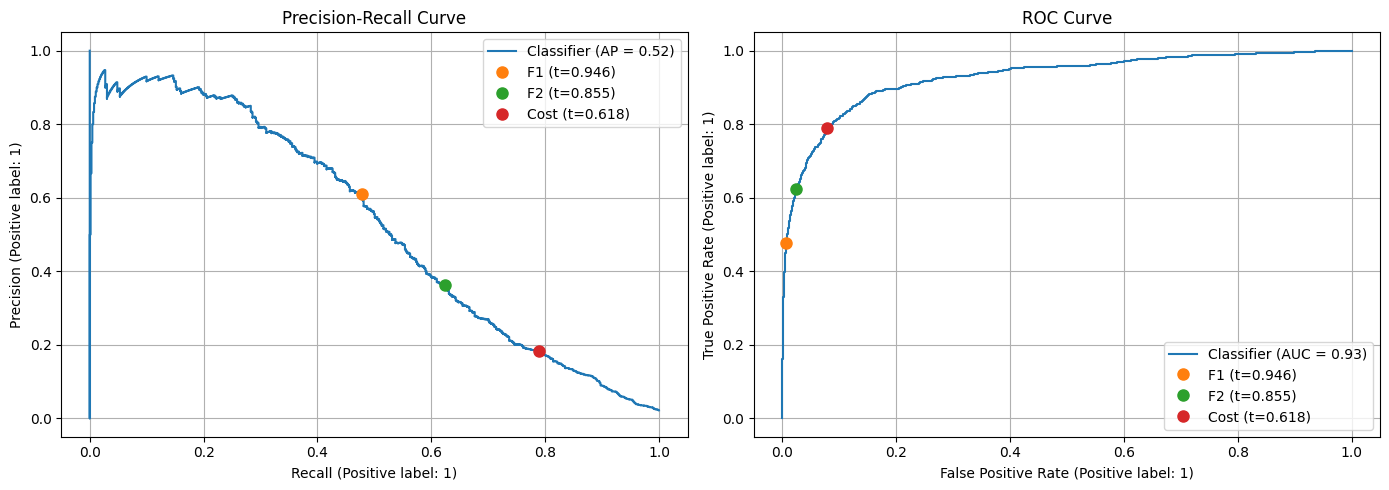

     MODEL: XGB
Fold 1: AUPRC=0.82490 | P@K=0.80983
Fold 2: AUPRC=0.81768 | P@K=0.80891
Fold 3: AUPRC=0.81366 | P@K=0.79314
Fold 4: AUPRC=0.81822 | P@K=0.79592
Fold 5: AUPRC=0.80474 | P@K=0.78942

Training final model on full training data...

OPTIMAL THRESHOLDS
Best F1   : 0.9533
Best F2   : 0.7353
Best Cost : 0.4560

PERFORMANCE @ Best F1 Threshold
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29309
           1       0.92      0.66      0.77       661

    accuracy                           0.99     29970
   macro avg       0.96      0.83      0.88     29970
weighted avg       0.99      0.99      0.99     29970

[[29272    37]
 [  223   438]]

PERFORMANCE @ Best COST Threshold
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29309
           1       0.46      0.83      0.59       661

    accuracy                           0.97     29970
   macro avg       0.73      0.90   

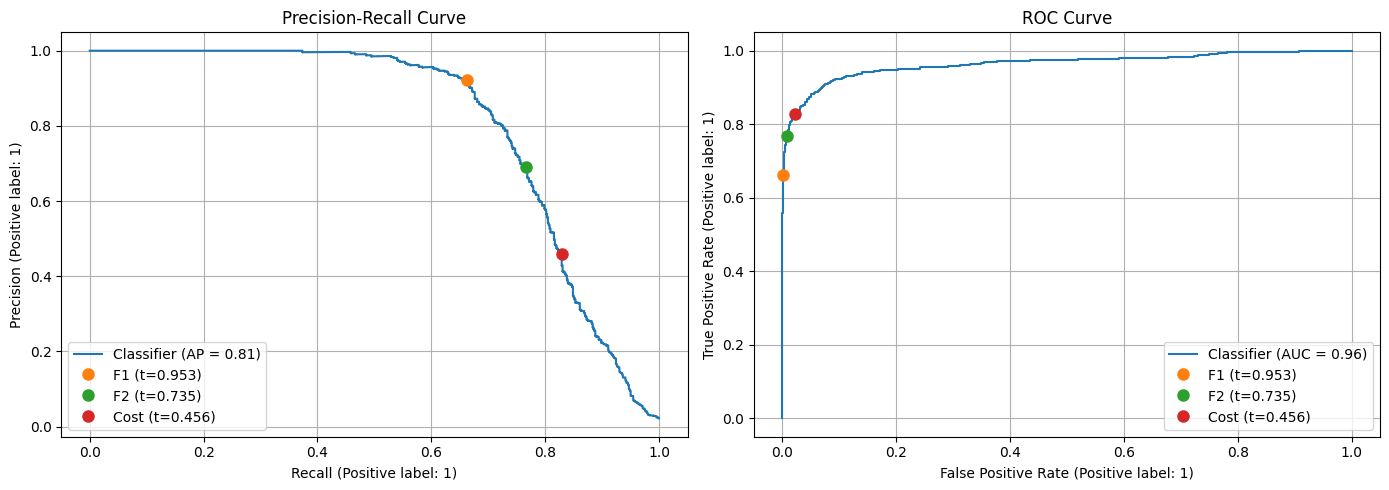

     MODEL: LGBM
Fold 1: AUPRC=0.82040 | P@K=0.80056
Fold 2: AUPRC=0.82080 | P@K=0.81169
Fold 3: AUPRC=0.81410 | P@K=0.79406
Fold 4: AUPRC=0.81350 | P@K=0.78757
Fold 5: AUPRC=0.80037 | P@K=0.78664

Training final model on full training data...

OPTIMAL THRESHOLDS
Best F1   : 0.9420
Best F2   : 0.7239
Best Cost : 0.5720

PERFORMANCE @ Best F1 Threshold
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29309
           1       0.90      0.69      0.78       661

    accuracy                           0.99     29970
   macro avg       0.95      0.84      0.89     29970
weighted avg       0.99      0.99      0.99     29970

[[29259    50]
 [  208   453]]

PERFORMANCE @ Best COST Threshold
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29309
           1       0.53      0.82      0.64       661

    accuracy                           0.98     29970
   macro avg       0.76      0.90  

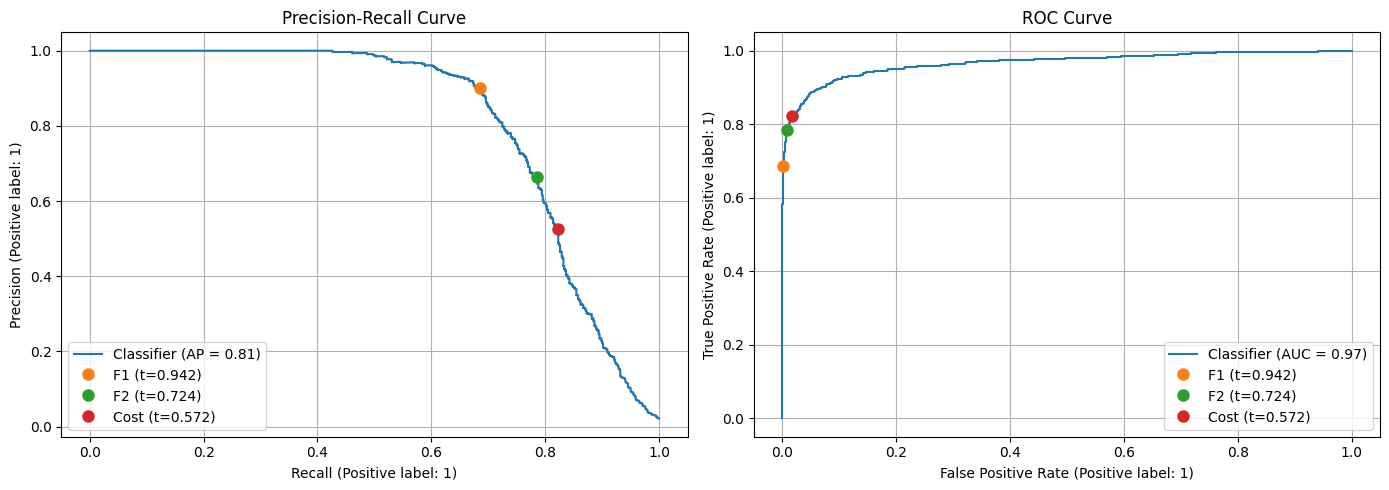

     MODEL: CATBOOST
Fold 1: AUPRC=0.81722 | P@K=0.80148
Fold 2: AUPRC=0.80313 | P@K=0.78108
Fold 3: AUPRC=0.80348 | P@K=0.78850
Fold 4: AUPRC=0.81153 | P@K=0.79035
Fold 5: AUPRC=0.80068 | P@K=0.77737

Training final model on full training data...

OPTIMAL THRESHOLDS
Best F1   : 0.9053
Best F2   : 0.8621
Best Cost : 0.6580

PERFORMANCE @ Best F1 Threshold
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29309
           1       0.75      0.73      0.74       661

    accuracy                           0.99     29970
   macro avg       0.87      0.86      0.87     29970
weighted avg       0.99      0.99      0.99     29970

[[29151   158]
 [  178   483]]

PERFORMANCE @ Best COST Threshold
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29309
           1       0.46      0.83      0.59       661

    accuracy                           0.97     29970
   macro avg       0.73      0.

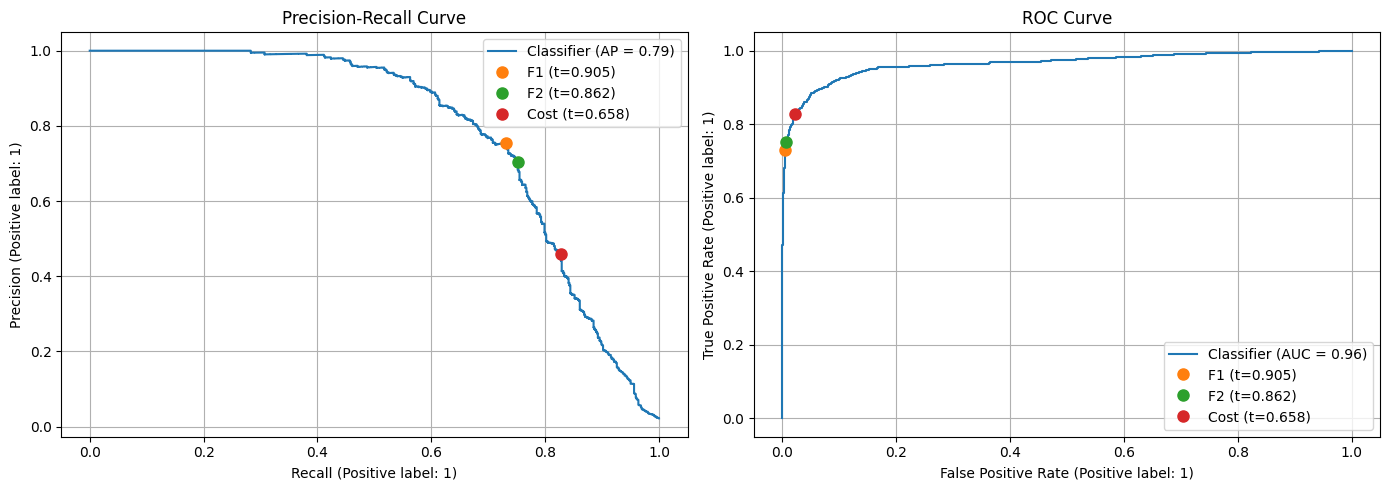

In [39]:
# Training & Evaluate
results = evaluate_models_gpu_threshold_tuning(
    X_train, y_train,
    X_test, y_test,
    cat_cols, num_cols
)

### Based on Training and Evaluation Results — Phase 2 (Threshold Tuning)
------------------------------------------------------------------------------------------------------------------------------------------------------

#### After applying threshold tuning, the model performance showed a significant improvement in separating fraud and non-fraud transactions. This process also highlighted the natural trade-off between recall and precision, which is expected since adjusting the threshold shifts the balance between two opposing objectives: maximizing fraud detection (recall) or minimizing false positives (precision).

#### Using threshold tuning based on **F1**, **F2**, and **Cost-Based Optimization**, the following decision strategy was defined:

---

#### **If the goal is automatic transaction blocking**
➡ Recommended threshold: **F1-based → 0.9533**

- Delivers very high precision  
- Minimizes false positives  
- Suitable for **hard-block decision systems**

---

#### **If the goal is generating alerts for fraud analysts**
➡ Recommended threshold: **Cost-based → 0.4560**

- Provides much higher recall  
- Captures significantly more fraud cases  
- Suitable for **investigation pipelines or manual review queues**

---

#### **If the goal is using a hybrid decision system**
➡ Use a probability-based classification scheme:

| Model Probability | Decision Type |
|-------------------|---------------|
| **> 0.95**        | Auto-block |
| **0.45 – 0.95**   | Send to manual review |
| **< 0.45**        | Approve transaction |

This hybrid strategy is commonly used in real-world fraud detection systems because it balances model accuracy, analyst workload, and user experience.

------------------------------------------------------------------------------------------------------------------------------------------------------

#### Next improvement opportunities (not executed in this project due to time constraints):

- Applying **Undersampling, SMOTE, or other class-balancing strategies**
- **Hyperparameter tuning** using Grid Search or Optuna
- Building an **ensemble via StackingClassifier**
- Developing **advanced feature engineering** (behavior sequence, velocity, temporal patterns)

These steps may further improve performance and robustness in future iterations.


# Executive Summary — Fraud Detection Project
------------------------------------------------------------------------------------------------------------------------------------------------------
![](https://www.fraud.com/wp-content/uploads/2023/02/Fraud-Analysis.jpg)

#### This project aims to develop a fraud detection system capable of effectively identifying suspicious transactions in a large-scale dataset with a high level of class imbalance. Through a series of processes—including exploratory analysis, preprocessing, modeling, and threshold tuning—the resulting model demonstrates strong accuracy and detection capability aligned with operational requirements.

#### The dataset contains approximately 300,000 transactions with no missing values or duplicates, but only **2.2%** of them are classified as fraud. Early analysis revealed that features such as account age, transaction amount, shipping distance, AVS/CVV matching, and 3D Secure usage are strong predictors that differentiate fraudulent transactions from legitimate ones.

#### Four main models were evaluated: Logistic Regression, XGBoost, LightGBM, and CatBoost. From the initial evaluation:

- #### **XGBoost achieved the highest precision**, making it the best choice when the primary focus is reducing false positives.

- #### **CatBoost achieved the highest recall**, making it more effective at capturing as many fraudulent transactions as possible.

#### To align detection performance with business objectives, threshold tuning was performed using F1, F2, and Cost-Based Optimization methods. The outcomes were as follows:

- #### The **F1-based threshold** is suitable for **automatic transaction blocking**, as it maintains a low false-positive rate.

- #### The **Cost-Based threshold** is ideal for **fraud analyst review**, as it maximizes the number of detected fraud cases.

- #### The **hybrid approach** combines both strategies by splitting transactions into three categories: block, review, and approve.

---

#### Overall, this project produced a fraud detection model that is strong, adaptable, and aligned with real-world risk management strategies. The solution not only reduces potential financial loss from fraud but also optimizes analyst workload while maintaining a smooth user experience.  

#### The model is ready for further development toward production deployment through advanced feature engineering, system integration, and continuous performance monitoring.


*By: Fikri Kurnia*